# mpi manager - granularity plugin


- *Steps*
    1. Import Scanflow and check the local environment
    2. Create Scanflow environment for mpiworkloads (namespace, agents)
    3. ****[RUN MPI Workloads]****
        1. exp1
        2. exp2
        3. exp3
    6. Clean environment

## Steps
### Step1: Import Scanflow and check the local environment
1. import scanflow
    - For defining and building scanflow application, we need to import ScanflowClient
    - For deploying scanflow application, we need to import ScanflowDeployerClient
2. check local environment
    - For deploying scanflow application
        - If user starts the notebook at local and has the privilege to submit object on Kubernetes. We don't need to configure "SCANFLOW_SERVER_URI"
        - If user starts the notebook inside Kubernetes pod, or the local user does not have privilege to connect Kubernetes. We need to configure "SCANFLOW_SERVER_URI"
    - For saving deliverables, we need to configure url of Scanflow-tracker on "SCANFLOW_TRACKER_URI" and url of Scanflow-local-tracker on "SCANFLOW_TRACKER_LOCAL_URI"
    - If Scanflow-tracker is using S3 artifact storage, we need to configure S3 url "MLFLOW_S3_ENDPOINT_URL", username "AWS_ACCESS_KEY_ID" and password "AWS_SECRET_ACCESS_KEY"

In [1]:
import sys
import os
sys.path.insert(0,'../..')

import scanflow
from scanflow.client import ScanflowClient
from scanflow.client import ScanflowDeployerClient

import time

In [2]:
from scanflow.tools import env
print(env.get_env("SCANFLOW_SERVER_URI"))
print(env.get_env("SCANFLOW_TRACKER_URI"))
#print(env.get_env("SCANFLOW_TRACKER_LOCAL_URI"))
print(env.get_env("MLFLOW_S3_ENDPOINT_URL"))
print(env.get_env("AWS_ACCESS_KEY_ID"))
print(env.get_env("AWS_SECRET_ACCESS_KEY"))

http://172.30.0.50:46666
http://172.30.0.50:46667
http://172.30.0.50:43447
admin
admin123


### Step2: Create scanflow environment (local/incluster)
  
  1. Import ScanflowClient to define mpiworkloads
  1. Create k8s environment
        - create namespace
        - create RBAC, secret, configmap, PV, PVC
        
  2. Deploy scanflow-local-tracker (deployment, service)

       

In [3]:
# App folder
scanflow_path = "/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow"
app_dir = os.path.join(scanflow_path, "examples/mpi/dataengineer")
app_name = "mpi"
team_name = "dataengineer"

# scanflow client
client = ScanflowClient(
              #if you defined "SCANFLOW_SERVER_URI", you dont need to provide this
              #scanflow_server_uri="http://172.30.0.50:46666",
              verbose=True)

In [4]:
deployerClient = ScanflowDeployerClient(user_type="local",
                                        deployer="volcano",
                                        k8s_config_file="/gpfs/bsc_home/xpliu/.kube/config")

12-Mar-22 00:27:06 -  INFO - loading kubernetes configuration from /gpfs/bsc_home/xpliu/.kube/config
12-Mar-22 00:27:06 -  INFO - found local kubernetes configuration


In [5]:
await deployerClient.create_environment(app=build_app)

NameError: name 'build_app' is not defined

### Step3: ****[RUN MPI Workloads]****


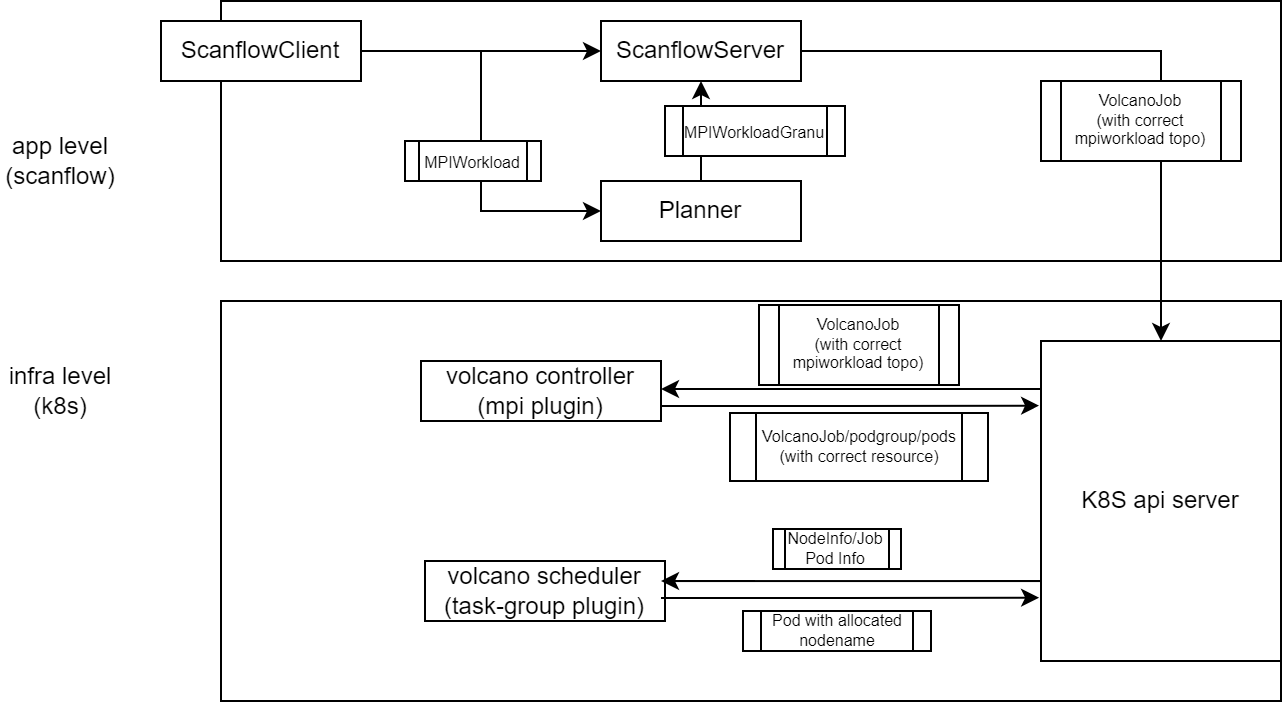

In [6]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/images/mpi/imp.png", width=1000, height=400)

In [7]:
def newWorkflow(i, benchmark, expstr, nTasks, nNodes):
    #mpi workloads
    mpi = client.ScanflowMPIWorkload(name=f"{benchmark}",
                                      mainfile=f"{benchmark}-{expstr}.yaml",
                                      nTasks=nTasks,
                                      nNodes=nNodes,)
    #workflow
    workflow = client.ScanflowWorkflow(type='mpi',
                                       name=f"{benchmark}{i}",
                                       nodes=[mpi],
                                       output_dir = "/home")
    return workflow

async def runWorkflow(i, build_app):
    return await deployerClient.run_workflow(app_name='mpi', 
                                  team_name='dataengineer',
                                  workflow = build_app.workflows[i])
    
async def deleteWorkflow(i, build_app):
    return await deployerClient.delete_workflow(app_name='mpi', 
                                  team_name='dataengineer',
                                  workflow = build_app.workflows[i])

In [8]:
from kubernetes import client as k8sclient
from kubernetes import config, utils
config.load_kube_config(config_file="/gpfs/bsc_home/xpliu/.kube/config")

def get_volcanoJob(namespace, name):
        api_client = k8sclient.CustomObjectsApi()
        try:
            return api_client.get_namespaced_custom_object(
                "batch.volcano.sh",
                "v1alpha1",
                namespace,
                "jobs",
                name,
            )
        except client.api_client.rest.ApiException as e:
            raise Exception("Exception when getting the vj workflow: %s\n" % e)

def get_vjstatus(namespace, name):
        api_client = k8sclient.CustomObjectsApi()
        try:
            response = api_client.get_namespaced_custom_object(
                "batch.volcano.sh",
                "v1alpha1",
                namespace,
                "jobs",
                name,
            )
            return response['status']
        except client.api_client.rest.ApiException as e:
            raise Exception("Exception when getting the vj workflow: %s\n" % e)
            
def get_vjstate(namespace, name):
        api_client = k8sclient.CustomObjectsApi()
        try:
            response = api_client.get_namespaced_custom_object(
                "batch.volcano.sh",
                "v1alpha1",
                namespace,
                "jobs",
                name,
            )
            return response['status']['state']['phase']
        except client.api_client.rest.ApiException as e:
            raise Exception("Exception when getting the vj workflow: %s\n" % e)
            
# def get_vjduration(namespace, name):
#         api_client = client.CustomObjectsApi()
#         try:
#             response = api_client.get_namespaced_custom_object(
#                 "batch.volcano.sh",
#                 "v1alpha1",
#                 namespace,
#                 "jobs",
#                 name,
#             )
#             if response['status']['state']['phase']=='Completed':
#                 return response['status']['runningDuration']
#             else:
#                 raise Exception("vj workflow: %s is not completed.\n" % e)
#         except client.api_client.rest.ApiException as e:
#             raise Exception("Exception when getting the vj workflow: %s\n" % e)
            
# def get_conditions(namespace, name):
#         api_client = client.CustomObjectsApi()
#         try:
#             response = api_client.get_namespaced_custom_object(
#                 "batch.volcano.sh",
#                 "v1alpha1",
#                 namespace,
#                 "jobs",
#                 name,
#             )
#             if response['status']['state']['phase']=='Completed':
#                 return response['status']['conditions']
#             else:
#                 raise Exception("vj workflow: %s is not completed.\n" % e)
#         except client.api_client.rest.ApiException as e:
#             raise Exception("Exception when getting the vj workflow: %s\n" % e)



In [9]:
import csv
import subprocess

header = ['benchmark','times','nTasks','nNodes','nWorkers',
          'Pending','Running','Completing','Completed',
          'duration','performance']

def get_conditionTime(conditions, status):
    for condition in conditions:
        if condition['status'] == status:
            return condition['lastTransitionTime']
    return None
   
def get_performanceflag(benchmark):
    return {
        "hpccfft": "MPIFFT_Gflops",
        "hpccdgemm": "StarDGEMM_Gflops",
        "hpccptrans": "PTRANS_GBs",
        "hpccrandomringbw": "RandomlyOrderedRingBandwidth_GBytes",
        "hpccrandomringlat": "RandomlyOrderedRingLatency_usec",
        "hpccrandomaccess": "MPIRandomAccess_GUPs",
        "hpccstream": "StarSTREAM_Triad",
    }[benchmark]

def writeCSVExp1(filename, namespace, workflowname, benchmark, outputdir, nTasks, nNodes):
    vjstatus = get_vjstatus(namespace,workflowname)
    conditions = vjstatus['conditions']
    duration = vjstatus['runningDuration']
    nWorkers = vjstatus['minAvailable'] - 1
    
#     dont use randomring as first
    if benchmark == "hpccrandomring":
        for benchmark in ["hpccrandomringbw","hpccrandomringlat"]:
            performancestr = get_performanceflag(benchmark)
            performance = subprocess.getoutput("grep {} {}/hpccoutf.txt | awk -F'=' '{}'"
                                    .format(performancestr, outputdir,"{print $2}"))
            print(f"{performancestr},{performance}")

            with open(f"{filename}.csv", "a", encoding="UTF8") as far:
                writer = csv.writer(far)
                writer.writerow([benchmark, workflowname[-1], nTasks, nNodes, nWorkers,
                                get_conditionTime(conditions, "Pending"),
                                get_conditionTime(conditions, "Running"),
                                get_conditionTime(conditions, "Completing"),
                                get_conditionTime(conditions, "Completed"),
                                duration, performance])
    else:
        performancestr = get_performanceflag(benchmark)
        performance = subprocess.getoutput("grep {} {}/hpccoutf.txt | awk -F'=' '{}'"
                                .format(performancestr, outputdir,"{print $2}"))
        print(f"{performancestr},{performance}")

        fileexist = os.path.isfile(f"{filename}.csv")
        if fileexist:
            with open(f"{filename}.csv", "a", encoding="UTF8") as fa:
                writer = csv.writer(fa)
                writer.writerow([benchmark, workflowname[-1], nTasks, nNodes, nWorkers,
                                get_conditionTime(conditions, "Pending"),
                                get_conditionTime(conditions, "Running"),
                                get_conditionTime(conditions, "Completing"),
                                get_conditionTime(conditions, "Completed"),
                                duration, performance])
        else:
            with open(f"{filename}.csv", "w", encoding="UTF8") as f:
                writer = csv.writer(f)
                writer.writerow(header)
                writer.writerow([benchmark, workflowname[-1], nTasks, nNodes, nWorkers,
                                get_conditionTime(conditions, "Pending"),
                                get_conditionTime(conditions, "Running"),
                                get_conditionTime(conditions, "Completing"),
                                get_conditionTime(conditions, "Completed"),
                                duration, performance])
        

In [10]:
# writeCSVExp1("exp1baseline", "scanflow-mpi-dataengineer", "hpccfft0", "hpccfft",
#                                  "/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccfft0-output",16,4)

In [11]:
# performancestr="MPIFFT_Gflops"
# outputdir="/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccfft0-output"
# subprocess.getoutput("grep {} {}/hpccoutf.txt | awk -F'=' '{}'".format(performancestr, outputdir,"{print $2}"))

In [12]:
# outputdir="/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccrandomring0-output"
# for benchmark in ["hpccrandomringbw","hpccrandomringlat"]:
#             performancestr = get_performanceflag(benchmark)
#             performance = subprocess.getoutput("grep {} {}/hpccoutf.txt | awk -F'=' '{}'"
#                                     .format(performancestr, outputdir,"{print $2}"))
#             print(f"{performancestr},{performance}")
            
#             with open(f"exp1baseline.csv", "a", encoding="UTF8") as f:
#                 writer = csv.writer(f)
#                 writer.writerow([benchmark, 0, 16, 4, 4,
#                                  "Pending",
#                                  "Running",
#                                  "Completing",
#                                  "Completed",
#                                 1, performance])

1. Exp1: 4 nodes - X10 times
         metrics: workload performance, workload complete time
         scenario
           baseline: app(16 tasks, 4 nodes) -> 4 worker
           more containers: app(16 tasks, 4 nodes) -> 16 workers
    (conclusion: more containers help "cpu/memory" intensive, similar in "network" intensive)
         

A. baseline: app(16 tasks, 4 nodes) -> 4 worker
         

In [13]:
workflows = []
for benchmark in ['hpccfft','hpccdgemm','hpccrandomring','hpccrandomaccess','hpccptrans','hpccstream']:
    for i in range(10):
        workflows.append(newWorkflow(i, benchmark, "exp1-baseline", 16, 4))
len(workflows)

60

In [14]:
app = client.ScanflowApplication(app_name = app_name,
                                 app_dir = app_dir,
                                 team_name = team_name,
                                 workflows=workflows)
# dic = app.to_dict()
build_app = client.build_ScanflowApplication(app = app, trackerPort=46672)
# build_app.to_dict()

In [ ]:
# Exp1-baseline
for i in range(len(workflows)):
    if await runWorkflow(i, build_app):
        check=True
        while(check):
            time.sleep (30)
            try:
                namespace = f"scanflow-{app_name}-{team_name}"
                workflowname = build_app.workflows[i].name
                benchmark = build_app.workflows[i].nodes[0].name
                nTasks = build_app.workflows[i].nodes[0].nTasks
                nNodes = build_app.workflows[i].nodes[0].nNodes
                print(f"{namespace}, {workflowname}, {benchmark}, {nTasks}, {nNodes}")
                if get_vjstate(namespace,workflowname) == 'Completed':
                    print("jobcompleted")
                    writeCSVExp1("exp1baseline", namespace, workflowname, benchmark,
                                 f"/gpfs/bsc_home/xpliu/pv/scanflow-output/{workflowname}-output",
                                nTasks, nNodes)
                    await deleteWorkflow(i, build_app)
                    check=False
            except e:
                print("wait, error{}".format(e))

12-Mar-22 00:27:53 -  INFO - [+] output dir /home
12-Mar-22 00:27:53 -  INFO - [+] Create hpccfft0 output PV
12-Mar-22 00:27:53 -  INFO - create_pv true
12-Mar-22 00:27:53 -  INFO - [+] Create hpccfft0 output PVC
12-Mar-22 00:27:53 -  INFO - create_pvc true
12-Mar-22 00:27:53 -  INFO - output dir created
12-Mar-22 00:27:53 -  INFO - volcano job {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccfft0'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': [], 'mpi': ['--nTasks=16', '--nWorkers=4']}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\ncp /opt/results/hpccinf.txt /home;\nsleep 60;\nmpirun --allow-run-as-root --hostfile ${MPI_HOST} --nooversubscribe --mca mpi_yield_when_idle 0 --mca btl ^openib,u

scanflow-mpi-dataengineer, hpccfft0, hpccfft, 16, 4


B. more containers: app(16 tasks, 4 nodes) -> 16 worker
         

In [ ]:
workflows = []
for benchmark in ['hpccfft','hpccdgemm','hpccrandomring','hpccrandomaccess','hpccptrans','hpccstream']:
# for benchmark in ['hpccdgemm']:
    for i in range(10):
        workflows.append(newWorkflow(i, benchmark, "exp1-morecontainers", 16, 4))
len(workflows)

In [ ]:
app = client.ScanflowApplication(app_name = app_name,
                                 app_dir = app_dir,
                                 team_name = team_name,
                                 workflows=workflows)
# dic = app.to_dict()
build_app = client.build_ScanflowApplication(app = app, trackerPort=46672)
# build_app.to_dict()

In [ ]:
# Exp1-morecontainers
for i in range(len(workflows)):
    if await runWorkflow(i, build_app):
        check=True
        while(check):
            time.sleep (30)
            try:
                namespace = f"scanflow-{app_name}-{team_name}"
                workflowname = build_app.workflows[i].name
                benchmark = build_app.workflows[i].nodes[0].name
                nTasks = build_app.workflows[i].nodes[0].nTasks
                nNodes = build_app.workflows[i].nodes[0].nNodes
                print(f"{namespace}, {workflowname}, {benchmark}, {nTasks}, {nNodes}")
                if get_vjstate(namespace,workflowname) == 'Completed':
                    print("jobcompleted")
                    writeCSVExp1("exp1morecontainers", namespace, workflowname, benchmark,
                                 f"/gpfs/bsc_home/xpliu/pv/scanflow-output/{workflowname}-output",
                                nTasks, nNodes)
                    await deleteWorkflow(i, build_app)
                    check=False
            except e:
                print("wait, error{}".format(e))

In [16]:
await deleteWorkflow(0, build_app)

12-Mar-22 00:17:52 -  INFO - can not find vj hpccdgemm0
12-Mar-22 00:17:52 -  ERROR - delete_pvc error
12-Mar-22 00:17:52 -  ERROR - delete_pv error


False


  
### Step4: Clean scanflow environment
  
  1. delete environment
  

In [16]:
await deployerClient.clean_environment(app=build_app)

10-Mar-22 12:29:05 -  INFO - [++] Stopping agent: [planner].
10-Mar-22 12:29:05 -  INFO - delete_deployment true
10-Mar-22 12:29:05 -  INFO - delete_service true
10-Mar-22 12:29:05 -  INFO - [++] Stopping tracker: [scanflow-tracker].
10-Mar-22 12:29:05 -  INFO - delete_deployment true
10-Mar-22 12:29:05 -  INFO - delete_service true
10-Mar-22 12:29:05 -  INFO - [++]Delete tracker configmap scanflow-tracker-env
10-Mar-22 12:29:05 -  INFO - delete_configmap true
10-Mar-22 12:29:05 -  INFO - [++]Delete client configmap scanflow-client-env
10-Mar-22 12:29:05 -  INFO - delete_configmap true
10-Mar-22 12:29:05 -  INFO - [++]Delete s3 secret scanflow-secret
10-Mar-22 12:29:05 -  INFO - delete_secret true
10-Mar-22 12:29:05 -  INFO - [++]Delete rolebinding default-admin
10-Mar-22 12:29:05 -  INFO - delete_rolebinding info
10-Mar-22 12:29:05 -  INFO - [++]Delete namespace "scanflow-mpi-dataengineer"
10-Mar-22 12:29:05 -  INFO - delete_namespace true
10-Mar-22 12:29:05 -  INFO - delete_pvc true
